Data Set: [LISA Traffic Light Dataset](https://www.kaggle.com/mbornoe/lisa-traffic-light-dataset)  

## 1. Importing Necessary Libraries

In [1]:
# General
import warnings
warnings.filterwarnings("ignore")
import datetime
from time import time
import pandas as pd
import os
import numpy as np
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
# OpenCV
import cv2

# ScikitLearn for Data Splitting
from sklearn.model_selection import train_test_split, GroupKFold, StratifiedKFold

# Albumentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

# Pytorch
import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.ops import nms

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalMaxPooling2D, Dense, Reshape

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


## 2. Load Data

In [3]:
DATA_PATH = '../data/LISATrafficLightDataset'
os.listdir(DATA_PATH)

['Annotations',
 'daySequence1',
 'daySequence2',
 'dayTrain',
 'nightSequence1',
 'nightSequence2',
 'nightTrain',
 'sample-dayClip6',
 'sample-nightClip1']

In [4]:
DAY_TRAIN_PATH = '../data/LISATrafficLightDataset/Annotations/Annotations/dayTrain/'

### Merge all different Annotation Files into a single file

In [5]:
train_day = []
for clipName in tqdm(sorted(os.listdir(DAY_TRAIN_PATH))):
    if 'dayClip' not in clipName:
        continue
    df = pd.read_csv(os.path.join(DAY_TRAIN_PATH,clipName,'frameAnnotationsBOX.csv'),sep=';')
    train_day.append(df)
    
train_day_df = pd.concat(train_day,axis=0)

df = pd.concat([train_day_df],axis=0)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 53.24it/s]


In [6]:
df.head()

,Filename,Annotation tag,Upper left corner X,Upper left corner Y,Lower right corner X,Lower right corner Y,Origin file,Origin frame number,Origin track,Origin track frame number
0,dayTraining/dayClip1--00000.jpg,go,698,333,710,358,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,0,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,0
1,dayTraining/dayClip1--00000.jpg,go,846,391,858,411,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,0,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,0
2,dayTraining/dayClip1--00001.jpg,go,698,337,710,357,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,1,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,1
3,dayTraining/dayClip1--00001.jpg,go,847,390,859,410,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,1,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,1
4,dayTraining/dayClip1--00002.jpg,go,698,331,710,356,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,2,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,2


## 3. Data Preprocessing

In [7]:
# Duplicate Columns
np.all(df['Origin file'] == df['Origin track']), np.all(df['Origin frame number'] == df['Origin track frame number'])

(True, True)

In [8]:
df = df.drop(['Annotation tag','Origin file','Origin track','Origin track frame number','Origin frame number'],axis=1)

In [9]:
def changeFilename(x):
    filename = x.Filename
    
    splitted = filename.split('/')
    clipName = splitted[-1].split('--')[0]
    return os.path.join(DATA_PATH,f'dayTrain/dayTrain/{clipName}/frames/{splitted[-1]}')

df['Filename'] = df.apply(changeFilename,axis=1)

In [10]:
df.columns = ['image_id','x_min','y_min','x_max','y_max']

In [11]:
df.head()

,image_id,x_min,y_min,x_max,y_max
0,../data/LISATrafficLightDataset\dayTrain/dayTr...,698,333,710,358
1,../data/LISATrafficLightDataset\dayTrain/dayTr...,846,391,858,411
2,../data/LISATrafficLightDataset\dayTrain/dayTr...,698,337,710,357
3,../data/LISATrafficLightDataset\dayTrain/dayTr...,847,390,859,410
4,../data/LISATrafficLightDataset\dayTrain/dayTr...,698,331,710,356


## 4. Exploratory Data Analysis

In [12]:
print("Number of Unique Images: ",df.image_id.nunique(),'/',df.shape[0])

Number of Unique Images:  12775 / 37810


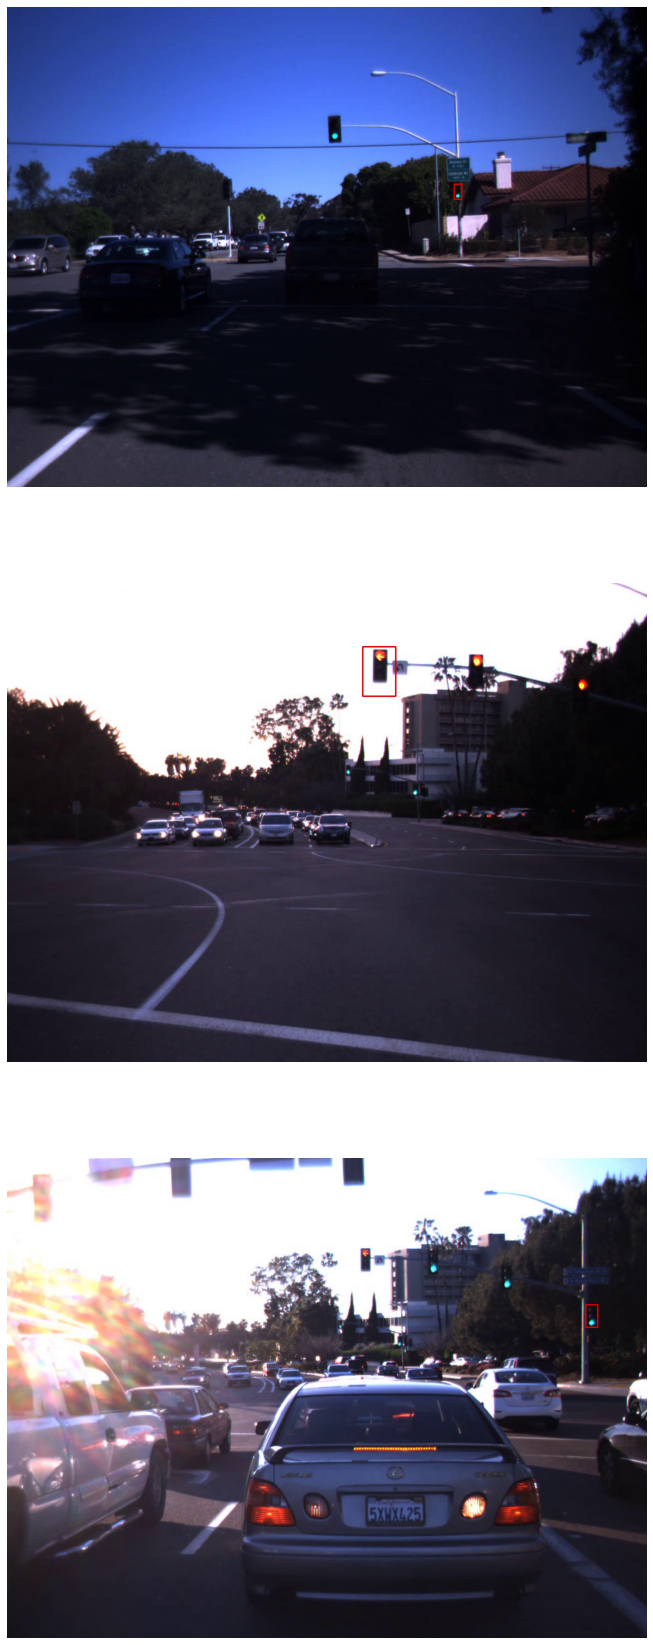

In [13]:
fig, ax = plt.subplots(3,1,figsize=(15,10*3))

for i in range(3):
    sample = df.sample(1)
    bbox = sample[['x_min','y_min','x_max','y_max']].values[0]
    
    image = cv2.imread(sample.image_id.values[0])
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    
    cv2.rectangle(image,(bbox[0],bbox[1]),(bbox[2],bbox[3]),(220, 0, 0), 2)
    
    ax[i].set_axis_off()
    ax[i].imshow(image)

# Data preprocessing

## 5. Validation Scheme

In [14]:
df['clipNames'] = df[['image_id']].applymap(lambda x: x.split('/')[4])
df['clipNames'].unique()

array(['dayClip1', 'dayClip10', 'dayClip11', 'dayClip12', 'dayClip13',
       'dayClip2', 'dayClip3', 'dayClip4', 'dayClip5', 'dayClip6',
       'dayClip7', 'dayClip8', 'dayClip9'], dtype=object)

### Train & Test Set split

In [15]:
numbers = [2,3,6,8,9,11,13]
random_number = np.random.choice(numbers)
numbers.remove(random_number)
random_number2 = np.random.choice(numbers)
numbers.remove(random_number2)

In [16]:
def split(df):
    clipNames = sorted(df['clipNames'].unique())

    dayClips = [name for name in clipNames]

    testDayClipNames = list(['dayClip'+str(random_number), 'dayClip'+str(random_number2)])
    print(testDayClipNames)
    testClipNames = testDayClipNames

    trainDayClipNames = list(set(dayClips) - set(testDayClipNames))
    trainClipNames = trainDayClipNames
    
    train_df = df[df.clipNames.isin(trainClipNames)]
    test_df = df[df.clipNames.isin(testClipNames)]
    
    return train_df, test_df

In [17]:
train_df, test_df = split(df)

['dayClip11', 'dayClip8']


In [18]:
train_df.head()

,image_id,x_min,y_min,x_max,y_max,clipNames
0,../data/LISATrafficLightDataset\dayTrain/dayTr...,698,333,710,358,dayClip1
1,../data/LISATrafficLightDataset\dayTrain/dayTr...,846,391,858,411,dayClip1
2,../data/LISATrafficLightDataset\dayTrain/dayTr...,698,337,710,357,dayClip1
3,../data/LISATrafficLightDataset\dayTrain/dayTr...,847,390,859,410,dayClip1
4,../data/LISATrafficLightDataset\dayTrain/dayTr...,698,331,710,356,dayClip1


In [19]:
test_df.head()

,image_id,x_min,y_min,x_max,y_max,clipNames
0,../data/LISATrafficLightDataset\dayTrain/dayTr...,150,324,168,360,dayClip11
1,../data/LISATrafficLightDataset\dayTrain/dayTr...,233,334,245,352,dayClip11
2,../data/LISATrafficLightDataset\dayTrain/dayTr...,346,398,364,416,dayClip11
3,../data/LISATrafficLightDataset\dayTrain/dayTr...,152,323,170,354,dayClip11
4,../data/LISATrafficLightDataset\dayTrain/dayTr...,348,396,366,414,dayClip11


In [20]:
print("Train shape: ",train_df.shape)
print("Test shape: ",test_df.shape)

Train shape:  (34557, 6)
Test shape:  (3253, 6)


### Train & Validation Split

In [21]:
random_number = np.random.choice(numbers)
numbers.remove(random_number)
random_number2 = np.random.choice(numbers)
numbers.remove(random_number2)

In [22]:
train_df, val_df = split(train_df)
train_df.head()

['dayClip9', 'dayClip3']


,image_id,x_min,y_min,x_max,y_max,clipNames
0,../data/LISATrafficLightDataset\dayTrain/dayTr...,698,333,710,358,dayClip1
1,../data/LISATrafficLightDataset\dayTrain/dayTr...,846,391,858,411,dayClip1
2,../data/LISATrafficLightDataset\dayTrain/dayTr...,698,337,710,357,dayClip1
3,../data/LISATrafficLightDataset\dayTrain/dayTr...,847,390,859,410,dayClip1
4,../data/LISATrafficLightDataset\dayTrain/dayTr...,698,331,710,356,dayClip1


In [23]:
val_df.head()

,image_id,x_min,y_min,x_max,y_max,clipNames
0,../data/LISATrafficLightDataset\dayTrain/dayTr...,622,361,637,379,dayClip3
1,../data/LISATrafficLightDataset\dayTrain/dayTr...,622,358,637,380,dayClip3
2,../data/LISATrafficLightDataset\dayTrain/dayTr...,506,382,518,404,dayClip3
3,../data/LISATrafficLightDataset\dayTrain/dayTr...,620,358,638,380,dayClip3
4,../data/LISATrafficLightDataset\dayTrain/dayTr...,504,382,519,404,dayClip3


In [24]:
print("Train shape: ",train_df.shape)
print("Validation shape: ",val_df.shape)

Train shape:  (31486, 6)
Validation shape:  (3071, 6)


# Train prep

In [25]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [26]:
import torch
torch.cuda.empty_cache()

import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = '2048'
max_split_size_mb = 512

In [27]:
def preprocess_annotations(input):
#     processed_annotations = np.zeros((input.shape[0], input.shape[1]), dtype=np.float32)
    processed_annotations = np.zeros((input.shape[0], 30, 40, 5), dtype=np.float32)
#     print(cv2.imread(input[0][0]).shape[0])

    index = 0
    for annotation in (input):
        x_min, y_min, x_max, y_max = annotation
#         x_min, y_min, x_max, y_max = [876, 143, 915, 203]
        
        

        # Calculate the center, height and width of the bounding box
        cx = (x_min + x_max) / 2.0
        cy = (y_min + y_max) / 2.0
        w = (x_max - x_min)
        h = (y_max - y_min)
        
        # Find the grid cell that the center of the bounding box falls in
        grid_x = int(cx / 40)
        grid_y = int(cy / 30)

        # Calculate the bounding box coordinates relative to the grid cell
        rel_center_x = (cx / 40 - grid_x) * 40
        rel_center_y = (cy / 30 - grid_y) * 30
#         rel_center_x = center_x
#         rel_center_y = center_y
        rel_bbox_width = w / 40
        rel_bbox_height = h / 30
#         rel_bbox_width = bbox_width * 7 / 1280
#         rel_bbox_height = bbox_height * 7 / 960

        # Set the objectness score to 1 in the corresponding grid cell
        processed_annotations[index, grid_y, grid_x, 0] = 1

        # Set the bounding box coordinates and class ID in the corresponding grid cell
        processed_annotations[index, grid_y, grid_x, 1] = rel_center_x
        processed_annotations[index, grid_y, grid_x, 2] = rel_center_y
        processed_annotations[index, grid_y, grid_x, 3] = rel_bbox_width
        processed_annotations[index, grid_y, grid_x, 4] = rel_bbox_height
        
        

        # append a row to the dataframe
#         processed_annotations[index] = [cx, cy, w, h]
        index = index + 1

    return processed_annotations

In [28]:
class TrafficLightsDataset:
    def __init__(self, df, transforms=None):
        super().__init__()

        # Image_ids will be the "Filename" here
        self.image_ids = df.image_id.unique()
        self.df = df
        self.transforms = transforms
        
    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        records = self.df[self.df.image_id == image_id]

        # Reading Image
        image = cv2.imread(image_id)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        # Bounding Boxes
        boxes = records[['x_min','y_min','x_max','y_max']].values
        
        new_boxes = preprocess_annotations(records[['x_min','y_min','x_max','y_max']].values)
        new_boxes = torch.as_tensor(new_boxes,dtype=torch.float32)

        target = new_boxes
        
        if self.transforms:
            sample = {
                'image': image,
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
        return image, target

In [29]:
train_df.head()

,image_id,x_min,y_min,x_max,y_max,clipNames
0,../data/LISATrafficLightDataset\dayTrain/dayTr...,698,333,710,358,dayClip1
1,../data/LISATrafficLightDataset\dayTrain/dayTr...,846,391,858,411,dayClip1
2,../data/LISATrafficLightDataset\dayTrain/dayTr...,698,337,710,357,dayClip1
3,../data/LISATrafficLightDataset\dayTrain/dayTr...,847,390,859,410,dayClip1
4,../data/LISATrafficLightDataset\dayTrain/dayTr...,698,331,710,356,dayClip1


In [30]:
# For Train Data
def getTransform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ])

In [31]:
trainDataset = TrafficLightsDataset(train_df[0:200], getTransform())
valDataset = TrafficLightsDataset(val_df[0:10], getTransform())
testDataset = TrafficLightsDataset(test_df[0:10], getTransform())

In [32]:
BATCH_SIZE = 16

trainDataLoader = DataLoader(
    trainDataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn
)

valDataLoader = DataLoader(
    valDataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn
)

testDataLoader = DataLoader(
    testDataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn
)

In [33]:
images, targets = next(iter(trainDataLoader))

boxes = targets[0].cpu().numpy().astype(np.float32)
image = images[0].permute(1,2,0).cpu().numpy()

In [34]:
def mergeGrids(main_boxes):
    merged_grid = np.zeros((30, 40, 5), dtype=np.float32)

    grid_size = (40, 30)
    index = 0
    for box in main_boxes:
        for i in range(grid_size[1]):
            for j in range(grid_size[0]):
                if main_boxes[index, i, j, 0] == 1:
                    cx, cy, w, h = main_boxes[index, i, j, 1:5].astype(float)
                    
                    merged_grid[i,j,0] = 1
                    merged_grid[i,j,1] = cx
                    merged_grid[i,j,2] = cy
                    merged_grid[i,j,3] = w
                    merged_grid[i,j,4] = h

        index = index+1

    return merged_grid

In [35]:
def displayImage(image, main_boxes):
    fig, ax = plt.subplots(1, 1, figsize=(16, 16))

    grid_size = (40, 30)

    # Draw the grid on the image
    for i in range(grid_size[0], image.shape[1], grid_size[0]):
        cv2.line(image, (i, 0), (i, image.shape[0]), (0, 1, 0), 1)
    for i in range(grid_size[1], image.shape[0], grid_size[1]):
        cv2.line(image, (0, i), (image.shape[1], i), (0, 1, 0), 1)

    for i in range(grid_size[1]):
        for j in range(grid_size[0]):
            if main_boxes[i, j, 0] == 1:
                cx, cy, w, h = main_boxes[i, j, 1:5].astype(float)

                cv2.circle(image, (int(40*j+cx), int(30*i+cy)), 3, (1, 1, 0), -1)
                cv2.rectangle(image,
                      (int(40*j+cx-40*w/2), int(30*i+cy-30*h/2)),
                      (int(40*j+cx+40*w/2), int(30*i+cy+30*h/2)),
                      (1, 0, 0), 2)

    ax.set_axis_off()
    ax.imshow(image)

    plt.show()

In [36]:
# type(mergeGrids(boxes))

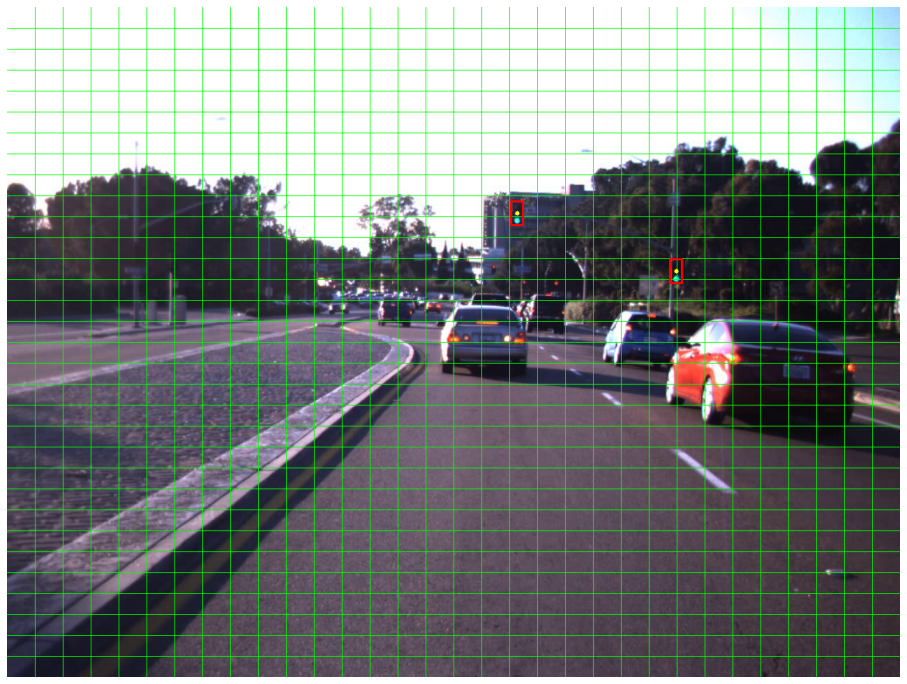

In [37]:
displayImage(image, mergeGrids(boxes))

In [38]:
# def custom_loss(y_true, y_pred):
#     # Extract the binary classification labels
#     classification_true = tf.gather(y_true, indices=[0], axis=-1)
#     classification_pred = tf.gather(y_pred, indices=[0], axis=-1)
#     # Compute binary cross-entropy loss
# #     classification_loss = tf.keras.losses.binary_crossentropy(classification_true, tf.math.softmax(classification_pred))
#     classification_loss = tf.keras.losses.binary_crossentropy(classification_true, classification_pred, from_logits=True)
#     # Compute mean squared error loss for regression tasks
#     regression_true = tf.gather(y_true, indices=[1, 2, 3, 4], axis=-1)
#     regression_pred = tf.gather(y_pred, indices=[1, 2, 3, 4], axis=-1)
#     regression_loss = tf.keras.losses.mean_squared_error(regression_true, regression_pred)
#     # Combine the losses
#     total_loss = classification_loss + 4*regression_loss

#     return total_loss

In [39]:
# learning_rate = 0.001
# batch_size = 32
# epochs = 1

# import tensorflow as tf
# from tensorflow.keras.applications import EfficientNetB0
# from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalMaxPooling2D, Dense, Reshape

# # Define the input shape of the model
# input_shape = (960, 1280, 3)
# # early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
# # lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=8, min_lr=0.000001)

# backbone = EfficientNetB0(input_shape=input_shape, include_top=False, weights='imagenet')
# for layer in backbone.layers:
#     layer.trainable = False
    
# x = backbone.output
# x = Conv2D(filters=512, kernel_size=1, activation='relu', padding='same')(x)
# x = Conv2D(filters=5, kernel_size=1, activation='linear', padding='same')(x)

# # Create the model
# model = tf.keras.models.Model(inputs=backbone.input, outputs=x)

# # # Set the activation functions for the output layer
# # model.layers[-1].activation = tf.keras.activations.linear
# # model.layers[-2].activation = tf.keras.activations.sigmoid

# # Compile the model
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
#               loss='mse', 
#               metrics=['accuracy'])

In [40]:
import torch
torch.cuda.empty_cache()

import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = '2048'
max_split_size_mb = 512

In [41]:
# for images, targets in trainDataLoader:
#     mergedGrids = np.zeros((len(images), 30, 40, 5), dtype=np.float32)
    
#     images = torch.stack(images).to(device)
#     images = images.permute(0,2,3,1).cpu().numpy()
#     index = 0
#     for target in targets:
#         boxes = target.cpu().numpy().astype(np.float32)
#         mergedGrids[index] = mergeGrids(boxes)
#         index = index + 1


In [42]:
# images.shape

In [43]:
# type(mergedGrids)

In [44]:
# mergedGrids.shape

In [45]:
# images = images.permute(0,2,3,1).cpu().numpy()

In [46]:
# # image = images[0].permute(1,2,0).cpu().numpy()
# # boxes = targets[0]['boxes'].cpu().numpy().astype(np.float32)
# # print(targets[0]['boxes'][0].shape) 

# # imagen = torch.stack(image).to(device)
# # img = images.cpu().numpy()

# learning_rate = 0.001
# batch_size = 32
# epochs = 2

# import tensorflow as tf
# from tensorflow.keras.applications import EfficientNetB0
# from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalMaxPooling2D, Dense, Reshape

# # Define the input shape of the model
# input_shape = (960, 1280, 3)
# # early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
# # lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=8, min_lr=0.000001)

# backbone = EfficientNetB0(input_shape=input_shape, include_top=False, weights='imagenet')
# for layer in backbone.layers:
#     layer.trainable = False
    
# x = backbone.output
# x = Conv2D(filters=512, kernel_size=1, activation='relu', padding='same')(x)
# x = Conv2D(filters=5, kernel_size=1, activation='linear', padding='same')(x)

# # Create the model
# model = tf.keras.models.Model(inputs=backbone.input, outputs=x)

# # # Set the activation functions for the output layer
# # model.layers[-1].activation = tf.keras.activations.linear
# # model.layers[-2].activation = tf.keras.activations.sigmoid

# # Compile the model
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
#               loss=custom_loss, 
#               metrics=['accuracy'])

# history = model.fit(images, mergedGrids, epochs=epochs, batch_size=batch_size, shuffle=True)

In [47]:
# class TrafficLightsDataset:
#     def __init__(self, df, transforms=None):
#         super().__init__()

#         # Image_ids will be the "Filename" here
#         self.image_ids = df.image_id.unique()
#         self.df = df
#         self.transforms = transforms
        
#     def __len__(self) -> int:
#         return self.image_ids.shape[0]

#     def __getitem__(self, index: int):
#         image_id = self.image_ids[index]
#         records = self.df[self.df.image_id == image_id]

#         # Reading Image
#         image = cv2.imread(image_id)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
#         image /= 255.0

#         # Bounding Boxes
#         boxes = records[['x_min','y_min','x_max','y_max']].values
        
#         new_boxes = preprocess_annotations(records[['x_min','y_min','x_max','y_max']].values)
#         new_boxes = torch.as_tensor(new_boxes,dtype=torch.float32)

#         target = new_boxes
        
#         if self.transforms:
#             sample = {
#                 'image': image,
#             }
#             sample = self.transforms(**sample)
#             image = sample['image']
            
#         return image, target

In [48]:
import numpy as np
import keras

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, df, batch_size=32, dim=(960,1280), n_channels=3, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.df = df
        self.list_IDs = self.df.image_id.unique()
#         print(self.df)
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
#         print(int(len(self.list_IDs)))
#         print(int(np.floor(len(self.list_IDs) / self.batch_size)))
        
        return int(np.floor(len(self.list_IDs) / self.batch_size))
#         return len(self.list_IDs)

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, 30, 40, 5), dtype=int)

        # Generate data
        for i, image_id in enumerate(list_IDs_temp):
            # Reading Image
            image = cv2.imread(image_id)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
            image /= 255.0

            records = self.df[self.df.image_id == image_id]

            # Store sample
            X[i,] = image

            boxes = preprocess_annotations(records[['x_min','y_min','x_max','y_max']].values)
            mergedGrid = mergeGrids(boxes)
            y[i,] = mergedGrid
            
        return X, y

In [49]:
# import tensorflow as tf
# import numpy as np
# from keras import backend as K

# def custom_loss2(y_true, y_pred):
#     # Split true and predicted values for p, cx, cy, w, and h
#     true_p, true_cx, true_cy, true_w, true_h = tf.split(y_true, 5, axis=-1)
#     pred_p, pred_cx, pred_cy, pred_w, pred_h = tf.split(y_pred, 5, axis=-1)

#     # Compute binary cross-entropy loss for p value
#     bce_loss = tf.keras.losses.binary_crossentropy(true_p, pred_p, from_logits=True)

#     # Compute mean squared error loss for cx, cy, w, and h values
#     mse_loss = tf.keras.losses.mean_squared_error(true_cx, pred_cx) + \
#                tf.keras.losses.mean_squared_error(true_cy, pred_cy) + \
#                tf.keras.losses.mean_squared_error(true_w, pred_w) + \
#                tf.keras.losses.mean_squared_error(true_h, pred_h)

#     # Combine the two losses
#     loss = bce_loss + mse_loss
    
#     bce_loss_mean = K.mean(bce_loss)
#     mse_loss_mean = K.mean(mse_loss)

#     K.print_tensor(bce_loss_mean, message='BCE Loss Mean = ')
#     K.print_tensor(mse_loss_mean, message='MSE Loss Mean = ')
    
#     return loss


In [50]:
train_df[0:200].image_id.nunique()

105

In [106]:
# import tensorflow as tf

# # define constants
# GRID_H, GRID_W, NUM_BOXES = 30, 40, 5
# COORD_SCALE, NOOBJ_SCALE, OBJ_SCALE = 5.0, 0.5, 1.0

# def yolo_loss(y_true, y_pred):
#     # reshape the predictions into a 3D tensor
#     y_pred = tf.reshape(y_pred, [-1, GRID_H, GRID_W, NUM_BOXES])

#     # split the predictions into their respective components
#     pred_xy = y_pred[..., 1:3]     # (batch_size, grid_h, grid_w, num_boxes, 2)
#     pred_wh = y_pred[..., 3:5]     # (batch_size, grid_h, grid_w, num_boxes, 2)
#     pred_conf = y_pred[..., 0:1]   # (batch_size, grid_h, grid_w, num_boxes, 1)

#     # split the true labels into their respective components
#     true_xy = y_true[..., 1:3]     # (batch_size, grid_h, grid_w, num_boxes, 2)
#     true_wh = y_true[..., 3:5]     # (batch_size, grid_h, grid_w, num_boxes, 2)
#     true_conf = y_true[..., 0:1]   # (batch_size, grid_h, grid_w, num_boxes, 1)

#     # calculate the objectness score for each bounding box
#     object_mask = true_conf      # (batch_size, grid_h, grid_w, num_boxes, 1)
#     object_mask_bool = tf.cast(object_mask, dtype=tf.bool)
#     pred_box = tf.concat([pred_xy, pred_wh], axis=-1)     # (batch_size, grid_h, grid_w, num_boxes, 4)
#     true_box = tf.concat([true_xy, true_wh], axis=-1)     # (batch_size, grid_h, grid_w, num_boxes, 4)
#     iou_scores = calc_iou(true_box, pred_box)             # (batch_size, grid_h, grid_w, num_boxes, 1)
# #     best_iou = tf.reduce_max(iou_scores, axis=-1, keepdims=True)  # (batch_size, grid_h, grid_w, num_boxes, 1)
    
# #     object_mask = tf.cast(object_mask, tf.float32)

# #     # calculate the localization loss
# #     xy_loss = object_mask * COORD_SCALE * tf.reduce_sum(tf.square(tf.cast(true_xy, tf.float32) - pred_xy), axis=-1)
# #     wh_loss = object_mask * COORD_SCALE * tf.reduce_sum(tf.square(tf.cast(tf.sqrt(tf.cast(true_wh, tf.float32)) - tf.sqrt(tf.cast(pred_wh, tf.float32)), tf.float32)), axis=-1)
# # #     wh_loss = object_mask * COORD_SCALE * tf.reduce_sum(tf.square(tf.sqrt(true_wh) - tf.sqrt(pred_wh)), axis=-1)
# #     loc_loss = tf.reduce_sum(xy_loss + wh_loss, axis=[1, 2, 3])

# #     # calculate the confidence loss
# #     obj_loss = object_mask * OBJ_SCALE * tf.square(best_iou - pred_conf)
# #     noobj_loss = NOOBJ_SCALE * (1.0 - object_mask) * tf.square(0.0 - pred_conf)
# #     conf_loss = tf.reduce_sum(obj_loss + noobj_loss, axis=[1, 2, 3, 4])

# #     # calculate the total loss
# #     total_loss = loc_loss + conf_loss
    
#     best_iou = tf.reduce_max(iou_scores, axis=-1, keepdims=True)  # (batch_size, grid_h, grid_w, num_boxes, 1)
#     best_iou = tf.expand_dims(best_iou, axis=-1)  # (batch_size, grid_h, grid_w, num_boxes, 1, 1)

#     object_mask = tf.cast(object_mask, tf.float32)

#     # calculate the localization loss
#     xy_loss = object_mask * COORD_SCALE * tf.reduce_sum(tf.square(tf.cast(true_xy, tf.float32) - pred_xy), axis=-1)
#     wh_loss = object_mask * COORD_SCALE * tf.reduce_sum(tf.square(tf.cast(tf.sqrt(tf.cast(true_wh, tf.float32)) - tf.sqrt(tf.cast(pred_wh, tf.float32)), tf.float32)), axis=-1)
#     loc_loss = tf.reduce_sum(xy_loss + wh_loss, axis=[1, 2, 3])

#     # calculate the confidence loss
#     obj_loss = object_mask * OBJ_SCALE * tf.square(best_iou - pred_conf)
#     noobj_loss = NOOBJ_SCALE * (1.0 - object_mask) * tf.square(0.0 - pred_conf)
#     conf_loss = tf.reduce_sum(obj_loss + noobj_loss, axis=[1, 2, 3, 4])

#     # calculate the total loss
#     total_loss = loc_loss + conf_loss


#     return total_loss

# def calc_iou(true_box, pred_box):
#     # get the coordinates of bounding boxes
#     true_xy = tf.cast(true_box[..., 0:2], tf.float32)
#     true_wh = tf.cast(true_box[..., 2:4], tf.float32)
#     pred_xy = tf.cast(pred_box[..., 0:2], tf.float32)
#     pred_wh = tf.cast(pred_box[..., 2:4], tf.float32)

#     # calculate the intersection areas
#     true_mins = true_xy - tf.cast(true_wh / 2.0, tf.float32)
#     true_maxes = true_xy + tf.cast(true_wh / 2.0, tf.float32)
#     pred_mins = pred_xy - tf.cast(pred_wh / 2.0, tf.float32)
#     pred_maxes = pred_xy + tf.cast(pred_wh / 2.0, tf.float32)

#     intersect_mins = tf.maximum(true_mins, pred_mins)
#     intersect_maxes = tf.minimum(true_maxes, pred_maxes)
#     intersect_wh = tf.maximum(intersect_maxes - intersect_mins, 0.0)
#     intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]

#     # calculate the union areas
#     true_areas = true_wh[..., 0] * true_wh[..., 1]
#     pred_areas = pred_wh[..., 0] * pred_wh[..., 1]
#     union_areas = true_areas + pred_areas - intersect_areas

#     # calculate the IOU score
#     iou_scores = intersect_areas / union_areas
#     return iou_scores

In [51]:
import tensorflow as tf
import numpy as np
from keras import backend as K

def custom_loss(y_true, y_pred):
    print(y_true)
    print(y_pred)
    # Extract the binary classification labels
    classification_true = tf.gather(y_true, indices=[0], axis=-1)
    classification_pred = tf.gather(y_pred, indices=[0], axis=-1)
    # Compute binary cross-entropy loss
#     classification_loss = tf.keras.losses.binary_crossentropy(classification_true, tf.math.softmax(classification_pred))
    classification_loss = tf.keras.losses.binary_crossentropy(classification_true, classification_pred, from_logits=True)
    # Compute mean squared error loss for regression tasks
    regression_true = tf.gather(y_true, indices=[1, 2, 3, 4], axis=-1)
    regression_pred = tf.gather(y_pred, indices=[1, 2, 3, 4], axis=-1)
    regression_loss = tf.keras.losses.mean_squared_error(regression_true, regression_pred)
    # Combine the losses
    total_loss = classification_loss + regression_loss
    
    bce_loss_mean = K.mean(classification_loss)
    mse_loss_mean = K.mean(regression_loss)

    K.print_tensor(bce_loss_mean, message='\nBCE Loss Mean = ')
    K.print_tensor(mse_loss_mean, message='MSE Loss Mean = ')

    return total_loss

In [52]:
import tensorflow as tf

def custom_loss(y_true, y_pred):
    # Extract the p, cx, cy, w, h values from the labels
    y_true_p = y_true[:, :, :, 0]
    y_true_cx = y_true[:, :, :, 1]
    y_true_cy = y_true[:, :, :, 2]
    y_true_w = y_true[:, :, :, 3]
    y_true_h = y_true[:, :, :, 4]

    y_pred_p = y_pred[:, :, :, 0]
    y_pred_cx = y_pred[:, :, :, 1]
    y_pred_cy = y_pred[:, :, :, 2]
    y_pred_w = y_pred[:, :, :, 3]
    y_pred_h = y_pred[:, :, :, 4]

    # Calculate the binary cross-entropy loss for p
    bce_loss = tf.keras.losses.binary_crossentropy(
        tf.reshape(y_true_p, (-1, 30, 40, 1)),
        tf.reshape(y_pred_p, (-1, 30, 40, 1))
    )

    # Calculate the mean squared error loss for cx, cy, w, h
    mse_loss = tf.keras.losses.mean_squared_error(
        y_true[:, :, :, 1:],
        y_pred[:, :, :, 1:]
    )

    # Calculate the total loss as the sum of the two losses
    total_loss = bce_loss + mse_loss
    
    bce_loss_mean = K.mean(bce_loss)
    mse_loss_mean = K.mean(mse_loss)

    K.print_tensor(bce_loss_mean, message='\nBCE Loss Mean = ')
    K.print_tensor(mse_loss_mean, message='MSE Loss Mean = ')

    return total_loss


In [108]:
import tensorflow as tf

GRID_SIZE = (30, 40)
NUM_ANCHORS = 5
NUM_CLASSES = 0

def custom_loss(y_true, y_pred):
    # Reshape y_true and y_pred to match grid size and number of anchors
    y_true = tf.reshape(y_true, (-1, GRID_SIZE[0], GRID_SIZE[1], NUM_ANCHORS))
    y_pred = tf.reshape(y_pred, (-1, GRID_SIZE[0], GRID_SIZE[1], NUM_ANCHORS))

    # Split y_true and y_pred into their components
    true_conf, true_cx, true_cy, true_w, true_h = tf.split(y_true, num_or_size_splits=5, axis=-1)
    pred_conf, pred_cx, pred_cy, pred_w, pred_h = tf.split(y_pred, num_or_size_splits=5, axis=-1)

    # Convert input tensors to float32
    true_cx = tf.cast(true_cx, tf.float32)
    pred_cx = tf.cast(pred_cx, tf.float32)
    true_cy = tf.cast(true_cy, tf.float32)
    pred_cy = tf.cast(pred_cy, tf.float32)
    true_w = tf.cast(true_w, tf.float32)
    pred_w = tf.cast(pred_w, tf.float32)
    true_h = tf.cast(true_h, tf.float32)
    pred_h = tf.cast(pred_h, tf.float32)

    # Calculate the binary cross-entropy loss for object/non-object classification
    conf_loss = tf.keras.losses.binary_crossentropy(true_conf, pred_conf)

    # Calculate the mean squared error loss for bounding box regression
    box_loss = tf.keras.losses.mean_squared_error(true_cx, pred_cx) + \
               tf.keras.losses.mean_squared_error(true_cy, pred_cy) + \
               tf.keras.losses.mean_squared_error(tf.sqrt(true_w), tf.sqrt(pred_w)) + \
               tf.keras.losses.mean_squared_error(tf.sqrt(true_h), tf.sqrt(pred_h))

    # Return the total loss as a combination of the conf_loss and box_loss
    total_loss = conf_loss + box_loss
    return total_loss


In [ ]:
# Generators
training_generator = DataGenerator(df=train_df[0:1000])
validation_generator = DataGenerator(df=val_df[0:200], shuffle=False)

# Define the input shape of the model
input_shape = (960, 1280, 3)

# Create the model
backbone = EfficientNetB0(input_shape=input_shape, include_top=False, weights='imagenet')
for layer in backbone.layers:
    layer.trainable = False
    
x = backbone.output
x = Conv2D(filters=512, kernel_size=1, activation='relu', padding='same')(x)
x = Conv2D(filters=5, kernel_size=1, activation='linear', padding='same')(x)
model = tf.keras.models.Model(inputs=backbone.input, outputs=x)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=custom_loss, 
              metrics=['accuracy'])

# # Train model on dataset
history = model.fit_generator(generator=training_generator,
                    validation_data=validation_generator, epochs=1)
#                     max_queue_size = 10,
#                     workers=2)

# history = model.fit_generator(generator=training_generator, validation_data=validation_generator)

9/9 [==============================] - ETA: 0s - loss: nan - accuracy: 0.8864 

In [ ]:
# learning_rate = 0.001
# epochs = 2

# import tensorflow as tf
# from tensorflow.keras.applications import EfficientNetB0
# from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalMaxPooling2D, Dense, Reshape

# # Define the input shape of the model
# input_shape = (960, 1280, 3)

# # Create the model
# backbone = EfficientNetB0(input_shape=input_shape, include_top=False, weights='imagenet')
# for layer in backbone.layers:
#     layer.trainable = False
    
# x = backbone.output
# x = Conv2D(filters=512, kernel_size=1, activation='relu', padding='same')(x)
# x = Conv2D(filters=5, kernel_size=1, activation='linear', padding='same')(x)
# model = tf.keras.models.Model(inputs=backbone.input, outputs=x)

# # Compile the model
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
#               loss='mse', 
#               metrics=['accuracy'])

# # Train the model
# for epoch in range(epochs):
#     for batch_num, (images, targets) in enumerate(trainDataLoader):
#         train_annotations = np.zeros((len(images), 30, 40, 5), dtype=np.float32)
#         images = torch.stack(images).to(device)
#         train_images = images.permute(0, 2, 3, 1).cpu().numpy()
#         index = 0
#         for target in targets:
#             boxes = target.cpu().numpy().astype(np.float32)
#             train_annotations[index] = mergeGrids(boxes)
#             index = index + 1
#         loss, acc = model.train_on_batch(train_images, train_annotations)
#         print(f"Epoch {epoch+1}, Batch {batch_num+1}: loss={loss:.4f}, acc={acc:.4f}")


In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.legend()
plt.show()

In [ ]:
# test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
# print('Test accuracy:', test_acc)
# print('Test loss:', test_loss)

In [ ]:
# print(y_test[0])

In [ ]:
# print(predictions[0])